### Compute and compare mass-size relation b/w XLSSC 122 and 3DHST
- Dec 2/2020

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import galfit_helpers as gfh
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib as mpl
from scipy.stats import linregress
import multiprocessing as mp
from astropy.cosmology import WMAP9 as cosmo
import galfit_helpers as gfh
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load catalogs

In [2]:
# DHST_df = pd.read_csv('/data/emiln/XLSSC122_GalPops/Analysis/Results/3dhst_galfit_full.csv')
DHST_df = pd.read_csv('/data/emiln/XLSSC122_GalPops/Analysis/Results/3dhst_galfit_full_1p7_to_2p3.csv')
XLSSC_df = pd.read_csv('/data/emiln/XLSSC122_GalPops/Analysis/Results/hst_galfit_full.csv')

### HST mag diff dependence on re?

(0, 1)

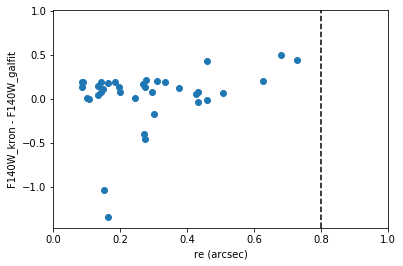

In [3]:

plt.scatter(XLSSC_df['re']*0.06,XLSSC_df['F140W']-XLSSC_df['mag'])
plt.axvline(0.8,linestyle='--',color='black')
plt.ylabel('F140W_kron - F140W_galfit')
plt.xlabel('re (arcsec)')
plt.xlim(0,1)

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
2  661  34.434096 -3.757658  4.4956  0.1854  0.8957  0.0099  3.0743  0.1384   

       mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
2  22.0689   0.0269  0.005471  0.00042  0.305518           0  


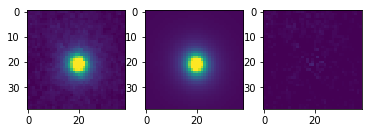

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
8  1065  34.435917 -3.749538  4.5865  0.3128  0.3704  0.0405  0.9374  0.2062   

       mag  mag_err    sky  sky_err   chi2nu  ErrorValue  
8  22.7974   0.0418  0.018   0.0009  16.4658           0  


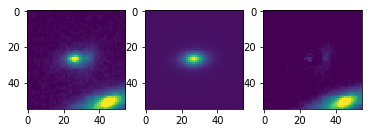

     ID         ra       dec        re    re_err      ar  ar_err        n  \
11  644  34.433802 -3.758806  164.7742  802.1895  0.5152  0.0404  15.6649   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
11  15.6956  21.5277   1.9587  0.0158    0.002  1.634471          16  


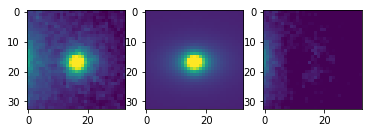

     ID         ra       dec       re    re_err      ar  ar_err        n  \
23  653  34.433963 -3.759267  28.3481  103.8835  0.6027  0.0586  15.8383   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
23  17.0176  22.8625   1.2796  0.0148   0.0012  0.741288          16  


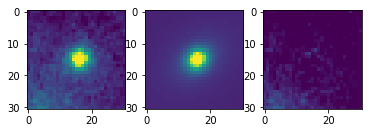

In [4]:
brighter_kron_df = XLSSC_df[(XLSSC_df['F140W']-XLSSC_df['mag'])<-0.2]
galfit_filename = 'XLSSC122_3ARCSEC_STELLAR_PSF_data_cps_sigma_rms_cps_w5HLR_639_3arcsec_PSF_5min_CONV128_CONSTR_DYNMAG'
for ID in brighter_kron_df['ID']:
    gfh.plot_by_ID(ID,save_name=galfit_filename,survey='HST')

### Correct XLSSC122 masses based on mag diff
 mag_kron - mag_galfit = 2.5*log10(mass_correction_factor)

In [5]:
XLSSC_df['mass_correction_factor'] = 10**((XLSSC_df['F140W'] - XLSSC_df['mag'])/2.5)
XLSSC_df['mass_OG'] = XLSSC_df['mass']
XLSSC_df['mass'] = XLSSC_df['mass_OG'] + np.log10(XLSSC_df['mass_correction_factor'])
XLSSC_df[['ID','mag','F140W','mass_correction_factor','mass','mass_OG']]

,ID,mag,F140W,mass_correction_factor,mass,mass_OG
0,529,19.7563,20.6356,2.247605,11.971635,11.619915
1,455,21.7323,21.9504,1.222475,10.842634,10.755394
2,661,22.0689,21.6681,0.691321,11.091393,11.251713
3,1036,21.9548,22.3846,1.485662,10.861213,10.689293
4,300,22.4572,22.5026,1.042702,10.986884,10.968724
5,920,22.5358,22.7254,1.190803,NaN,NaN
6,305,22.0240,22.5249,1.586208,11.022889,10.822529
7,1057,22.7747,22.8479,1.069744,10.610821,10.581541
8,1065,22.7974,22.3414,0.657052,10.559109,10.741509
9,608,22.8834,22.9910,1.104180,10.351157,10.308117


---------

In [6]:
DHST_df.columns.values

array(['ID', 'ra', 'dec', 're', 're_err', 'ar', 'ar_err', 'n', 'n_err',
       'mag', 'mag_err', 'sky', 'sky_err', 'chi2nu', 'ErrorValue', 'id',
       'x', 'y', 'faper_F160W', 'eaper_F160W', 'faper_F140W',
       'eaper_F140W', 'f_F160W', 'e_F160W', 'w_F160W', 'f_U', 'e_U',
       'w_U', 'f_B', 'e_B', 'w_B', 'f_G', 'e_G', 'w_G', 'f_V', 'e_V',
       'w_V', 'f_F606W', 'e_F606W', 'w_F606W', 'f_R', 'e_R', 'w_R',
       'f_Rp', 'e_Rp', 'w_Rp', 'f_I', 'e_I', 'w_I', 'f_Ip', 'e_Ip',
       'w_Ip', 'f_F814W', 'e_F814W', 'w_F814W', 'f_Z', 'e_Z', 'w_Z',
       'f_Zp', 'e_Zp', 'w_Zp', 'f_UVISTA_Y', 'e_UVISTA_Y', 'w_UVISTA_Y',
       'f_F125W', 'e_F125W', 'w_F125W', 'f_J1', 'e_J1', 'w_J1', 'f_J2',
       'e_J2', 'w_J2', 'f_J3', 'e_J3', 'w_J3', 'f_J', 'e_J', 'w_J',
       'f_UVISTA_J', 'e_UVISTA_J', 'w_UVISTA_J', 'f_F140W', 'e_F140W',
       'w_F140W', 'f_H1', 'e_H1', 'w_H1', 'f_H2', 'e_H2', 'w_H2', 'f_H',
       'e_H', 'w_H', 'f_UVISTA_H', 'e_UVISTA_H', 'w_UVISTA_H', 'f_K',
       'e_K', 'w_K', '

In [7]:
# Select quiescent galaxies in 3DHST
dhst_cthresh=2.0
DHST_df['color'] = DHST_df['F814W']-DHST_df['F140W']
qdhst_df = DHST_df[DHST_df['color']>dhst_cthresh]

# Select quiescent galaxies in 3DHST based on log SSFR # Quiescent log ssfr < - 9.6
# print len(DHST_df)
# qdhst_df = DHST_df[DHST_df['lssfr']<-9.6]
# print len(qdhst_df)
# qdhst_df = qdhst_df[qdhst_df['F140W']<24]
# print len(qdhst_df)

# Select redshift
zthresh=0.1
qdhst_df = qdhst_df[abs(qdhst_df['z']-2.0)<zthresh] # These are entirely photo-zs
print len(qdhst_df)




# qdhst_df
# print len(qdhst_df[bad_errs])
# print qdhst_df[['re','re_err']][bad_errs]
# qxlssc_df
kpa = cosmo.kpc_proper_per_arcmin(qdhst_df['z']).value/60
qdhst_df['re_kpc'] = qdhst_df['re']*0.06 * kpa # re[pixels] * 0.06 arcsec/pixel * kpa/arcsec
qdhst_df['re_err_kpc'] = qdhst_df['re_err']*0.06 * kpa # re[pixels] * 0.06 arcsec/pixel * kpa/arcsec

qdhst_df['re_maj_kpc'] = qdhst_df['re_kpc']/np.sqrt(qdhst_df['ar']) #https://arxiv.org/pdf/1506.01380.pdf p2
# Filter fits with bad errors
err_thresh = 0.5
bad_errs = (qdhst_df['re_err']/qdhst_df['re']) > err_thresh
print len(qdhst_df)
qdhst_df = qdhst_df[~bad_errs]
print len(qdhst_df)


30
30
22


In [8]:
# Select quiescent galaxies in XLSSC122
xlssc_cthresh = 1.1
qxlssc_df = XLSSC_df[XLSSC_df['color']>xlssc_cthresh]
kpa = cosmo.kpc_proper_per_arcmin(qxlssc_df['zz']).value/60
print kpa
qxlssc_df['re_kpc'] = qxlssc_df['re']*0.06 * kpa # re[pixels] * 0.06 arcsec/pixel * kpa/arcsec
qxlssc_df['re_err_kpc'] = qxlssc_df['re_err']*0.06 * kpa # re[pixels] * 0.06 arcsec/pixel * kpa/arcsec

O_qxlssc_df = qxlssc_df.copy()
print len(qxlssc_df)
# Exclude BCG (ID=529), ID=644 (contaminated by ICL, also no mass value, silver member), ID=240 (no mass value, silver member)
qxlssc_df = qxlssc_df[~qxlssc_df['ID'].isin([529,644,240])]
print len(qxlssc_df)


qxlssc_df['re_maj_kpc'] = qxlssc_df['re_kpc']/np.sqrt(qxlssc_df['ar']) #https://arxiv.org/pdf/1506.01380.pdf p2
# Filter fits with bad errors
err_thresh = 0.5
bad_errs = (qxlssc_df['re_err']/qxlssc_df['re']) > err_thresh
print len(qxlssc_df)
qxlssc_df = qxlssc_df[~bad_errs]
print len(qxlssc_df)

[8.56061572 8.56013441 8.5592908  8.55980504 8.55746668 8.5548464
 8.56164636 8.55699614 8.56644906 8.56156751 8.53272423 8.56076461
 8.55358038 8.5620286  8.55581319 8.56812653 8.55464594 8.55294377
 8.56524989 8.56159622 8.56159751]
21
18
18
18


In [9]:
O_qxlssc_df[O_qxlssc_df['ID']==240]
# O_qxlssc_df[O_qxlssc_df['spec-id']==240]
O_qxlssc_df[O_qxlssc_df['ID']==240][['mag', 'mag_err', 'sky', 'sky_err', 'chi2nu', 'ErrorValue',
       '(f140)kron', 'DEC', 'F140W', 'RA','f105_0p8',
       'color', 'em-code']]

,mag,mag_err,sky,sky_err,chi2nu,ErrorValue,(f140)kron,DEC,F140W,RA,f105_0p8,color,em-code
29,22.888,0.0211,-0.000592,0.000225,0.252314,0.0,23.0151,-3.770285,23.0151,34.45158,99.0,75.4647,1


### Compute mass-size relation

In [10]:
# apply mass completeness threshold from 3dhst, log10(m)>10.3
mthresh = 10.3
print len(qdhst_df)
masscomp_qdhst_df = qdhst_df[qdhst_df['lmass']>mthresh]
print len(masscomp_qdhst_df)
masscomp_qxlssc_df = qxlssc_df[qxlssc_df['mass']>mthresh]
print len(masscomp_qxlssc_df)

22
20
13


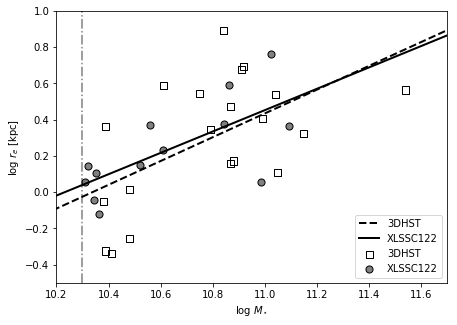

Field slope:0.66, Field int:-6.78, Field R^2:0.57
Cluster slope:0.59, Cluster int:-6.03, Clusterld R^2:0.69


In [12]:
df1 = masscomp_qdhst_df
df2 = masscomp_qxlssc_df
plt.figure(figsize=(7,5))
plt.scatter(df1['lmass'],np.log10(df1['re_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
plt.scatter(df2['mass'],np.log10(df2['re_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')
plt.xlabel('log $M_{\star}$')
plt.ylabel('log $r_e$ [kpc]')

ss, si, sr, sp, sstd = linregress(df1['lmass'],np.log10(df1['re_kpc']))
qs, qi, qr, qp, qstd = linregress(df2['mass'],np.log10(df2['re_kpc']))
X = np.linspace(10,12,10)
plt.plot(X,si+ss*X,linewidth=2,linestyle='--',color='black',label='3DHST')
plt.plot(X,qi+qs*X,linewidth=2,linestyle='-',color='black',label='XLSSC122')
plt.xlim(10.2,11.7)
plt.ylim(-0.5,1)
plt.legend()
plt.axvline(10.3,linestyle='-.',color='k',alpha=0.5)
plt.show()
# print('Field slope:{},',ss,'Field int:', si,'Field R^2:', sr)
print('Field slope:{:.2f}, Field int:{:.2f}, Field R^2:{:.2f}'.format(ss,si,sr))
# print sp, sstd
print('Cluster slope:{:.2f}, Cluster int:{:.2f}, Clusterld R^2:{:.2f}'.format(qs,qi,qr))
# print 'Cluster slope:', qs,'Cluster int:', qi, 'Cluster R^2:', qr
# print qp, qstd


### M/(5*10^10) and re_maj following vanderwel+2014

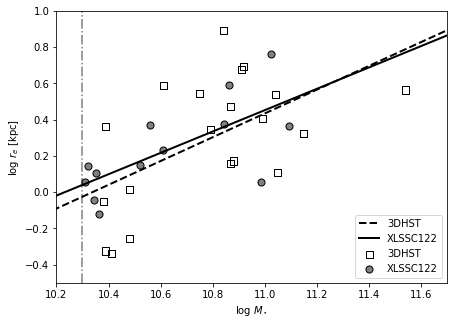

Field slope:0.66, Field int:0.24, Field R^2:0.57
Cluster slope:0.59, Cluster int:0.28, Clusterld R^2:0.69


In [31]:
df1 = masscomp_qdhst_df
df2 = masscomp_qxlssc_df
plt.figure(figsize=(7,5))
# plt.scatter(df1['lmass']-np.log10(5*10**10),np.log10(df1['re_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
# plt.scatter(df2['mass']-np.log10(5*10**10),np.log10(df2['re_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')

plt.scatter(df1['lmass'],np.log10(df1['re_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
plt.scatter(df2['mass'],np.log10(df2['re_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')
plt.xlabel(r'log $M_{\star}$')
plt.ylabel(r'log $r_e$ [kpc]')

ss, si, sr, sp, sstd = linregress(df1['lmass']-np.log10(5*10**10),np.log10(df1['re_kpc']))
qs, qi, qr, qp, qstd = linregress(df2['mass']-np.log10(5*10**10),np.log10(df2['re_kpc']))


X = np.linspace(10,12,10)
plt.plot(X,si+ss*(X-np.log10(5*10**10)),linewidth=2,linestyle='--',color='black',label='3DHST')
plt.plot(X,qi+qs*(X-np.log10(5*10**10)),linewidth=2,linestyle='-',color='black',label='XLSSC122')
plt.xlim(10.2,11.7)
# plt.xlim(-0.5,1)
plt.ylim(-0.5,1)
plt.legend()
plt.axvline(10.3,linestyle='-.',color='k',alpha=0.5)
plt.show()
# print('Field slope:{},',ss,'Field int:', si,'Field R^2:', sr)
print('Field slope:{:.2f}, Field int:{:.2f}, Field R^2:{:.2f}'.format(ss,si,sr))
# print sp, sstd
print('Cluster slope:{:.2f}, Cluster int:{:.2f}, Clusterld R^2:{:.2f}'.format(qs,qi,qr))
# print 'Cluster slope:', qs,'Cluster int:', qi, 'Cluster R^2:', qr
# print qp, qstd

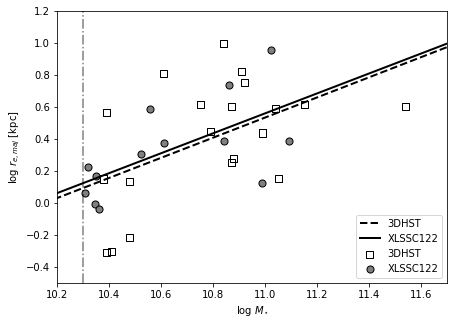

Field slope:0.63, Field int:0.34, Field R^2:0.51
Cluster slope:0.62, Cluster int:0.37, Clusterld R^2:0.62


In [29]:
df1 = masscomp_qdhst_df
df2 = masscomp_qxlssc_df
plt.figure(figsize=(7,5))
# plt.scatter(df1['lmass']-np.log10(5*10**10),np.log10(df1['re_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
# plt.scatter(df2['mass']-np.log10(5*10**10),np.log10(df2['re_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')

plt.scatter(df1['lmass'],np.log10(df1['re_maj_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
plt.scatter(df2['mass'],np.log10(df2['re_maj_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')
plt.xlabel(r'log $M_{\star}$')
plt.ylabel(r'log $r_{e,maj}$ [kpc]')

ss, si, sr, sp, sstd = linregress(df1['lmass']-np.log10(5*10**10),np.log10(df1['re_maj_kpc']))
qs, qi, qr, qp, qstd = linregress(df2['mass']-np.log10(5*10**10),np.log10(df2['re_maj_kpc']))


X = np.linspace(10,12,10)
plt.plot(X,si+ss*(X-np.log10(5*10**10)),linewidth=2,linestyle='--',color='black',label='3DHST')
plt.plot(X,qi+qs*(X-np.log10(5*10**10)),linewidth=2,linestyle='-',color='black',label='XLSSC122')
plt.xlim(10.2,11.7)
# plt.xlim(-0.5,1)
plt.ylim(-0.5,1.2)
plt.legend()
plt.axvline(10.3,linestyle='-.',color='k',alpha=0.5)
plt.show()
# print('Field slope:{},',ss,'Field int:', si,'Field R^2:', sr)
print('Field slope:{:.2f}, Field int:{:.2f}, Field R^2:{:.2f}'.format(ss,si,sr))
# print sp, sstd
print('Cluster slope:{:.2f}, Cluster int:{:.2f}, Clusterld R^2:{:.2f}'.format(qs,qi,qr))
# print 'Cluster slope:', qs,'Cluster int:', qi, 'Cluster R^2:', qr
# print qp, qstd

#### Boostrap field and test against cluster

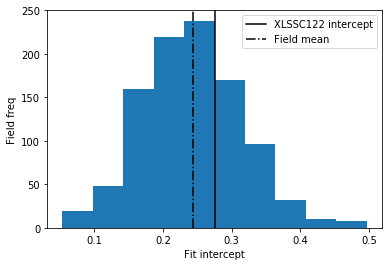

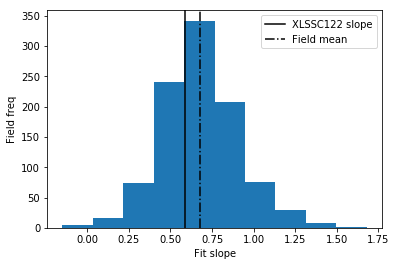

In [32]:
df1 = masscomp_qdhst_df
nboot = 1000
N = len(df1)
slopes = []
intercepts = []

for _ in range(0,nboot):
    tdf = df1.sample(n=N,replace=True)
    ss, si, sr, sp, sstd = linregress(tdf['lmass']-np.log10(5*10**10),np.log10(tdf['re_kpc']))
    slopes.append(ss)
    intercepts.append(si)

plt.hist(intercepts)
plt.axvline(qi,linestyle='-',color='k',label='XLSSC122 intercept')
plt.axvline(np.mean(intercepts),linestyle='-.',color='k',label='Field mean')
plt.xlabel('Fit intercept')
plt.ylabel('Field freq')
plt.legend()
plt.show()

plt.hist(slopes)
plt.axvline(qs,linestyle='-',color='k',label='XLSSC122 slope')
plt.axvline(np.mean(slopes),linestyle='-.',color='k',label='Field mean')
plt.xlabel('Fit slope')
plt.ylabel('Field freq')
plt.legend()
plt.show()

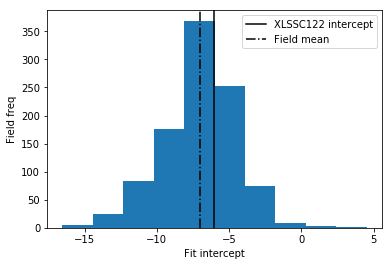

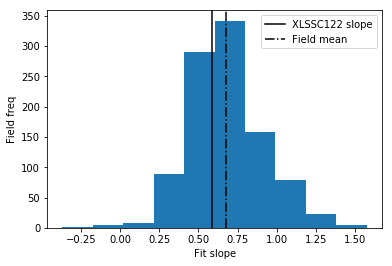

In [126]:
df1 = masscomp_qdhst_df
nboot = 1000
N = len(df1)
slopes = []
intercepts = []

for _ in range(0,nboot):
    tdf = df1.sample(n=N,replace=True)
    ss, si, sr, sp, sstd = linregress(tdf['lmass'],np.log10(tdf['re_kpc']))
    slopes.append(ss)
    intercepts.append(si)

plt.hist(intercepts)
plt.axvline(qi,linestyle='-',color='k',label='XLSSC122 intercept')
plt.axvline(np.mean(intercepts),linestyle='-.',color='k',label='Field mean')
plt.xlabel('Fit intercept')
plt.ylabel('Field freq')
plt.legend()
plt.show()

plt.hist(slopes)
plt.axvline(qs,linestyle='-',color='k',label='XLSSC122 slope')
plt.axvline(np.mean(slopes),linestyle='-.',color='k',label='Field mean')
plt.xlabel('Fit slope')
plt.ylabel('Field freq')
plt.legend()
plt.show()

### Fit major axis instead

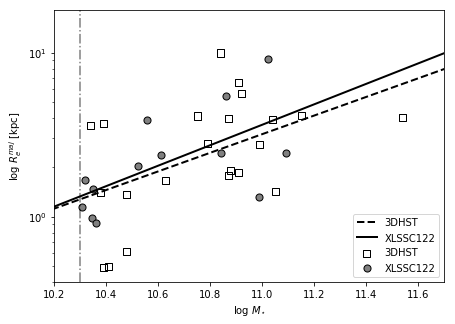

Field slope:0.57, Field int:-5.75, Field R^2:0.50
Cluster slope:0.62, Cluster int:-6.31, Clusterld R^2:0.62


In [79]:
df1 = masscomp_qdhst_df
df2 = masscomp_qxlssc_df
plt.figure(figsize=(7,5))
plt.scatter(df1['lmass'],df1['re_maj_kpc'],marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
plt.scatter(df2['mass'],df2['re_maj_kpc'],marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')

# plt.scatter(df1['lmass'],np.log10(df1['re_maj_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
# plt.scatter(df2['mass'],np.log10(df2['re_maj_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')

plt.xlabel('log $M_{\star}$')
plt.ylabel('log $R_e^{maj}$ [kpc]')

ss, si, sr, sp, sstd = linregress(df1['lmass'],np.log10(df1['re_maj_kpc']))
qs, qi, qr, qp, qstd = linregress(df2['mass'],np.log10(df2['re_maj_kpc']))
X = np.linspace(10,12,10)
# plt.plot(X,si+ss*X,linewidth=2,linestyle='--',color='black',label='3DHST')
# plt.plot(X,qi+qs*X,linewidth=2,linestyle='-',color='black',label='XLSSC122')

plt.plot(X,10**(si+ss*X),linewidth=2,linestyle='--',color='black',label='3DHST')
plt.plot(X,10**(qi+qs*X),linewidth=2,linestyle='-',color='black',label='XLSSC122')

plt.xlim(10.2,11.7)
# plt.ylim(0.5,10)
plt.legend()
plt.yscale('log')
plt.axvline(10.3,linestyle='-.',color='k',alpha=0.5)
plt.show()
# print('Field slope:{},',ss,'Field int:', si,'Field R^2:', sr)
print('Field slope:{:.2f}, Field int:{:.2f}, Field R^2:{:.2f}'.format(ss,si,sr))
# print sp, sstd
print('Cluster slope:{:.2f}, Cluster int:{:.2f}, Clusterld R^2:{:.2f}'.format(qs,qi,qr))
# print 'Cluster slope:', qs,'Cluster int:', qi, 'Cluster R^2:', qr
# print qp, qstd

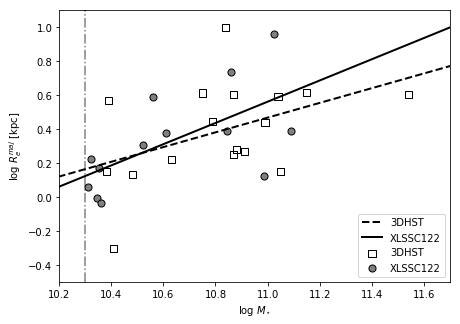

Field slope:0.43, Field int:-4.30, Field R^2:0.45
Cluster slope:0.62, Cluster int:-6.31, Clusterld R^2:0.62


In [26]:
df1 = masscomp_qdhst_df
df2 = masscomp_qxlssc_df
plt.figure(figsize=(7,5))
plt.scatter(df1['lmass'],np.log10(df1['re_maj_kpc']),marker='s',s=50,edgecolors='k',facecolors='none',label='3DHST')
plt.scatter(df2['mass'],np.log10(df2['re_maj_kpc']),marker='o',s=50,edgecolors='k',facecolors='gray',label='XLSSC122')
plt.xlabel('log $M_{\star}$')
plt.ylabel('log $R_e^{maj}$ [kpc]')

ss, si, sr, sp, sstd = linregress(df1['lmass'],np.log10(df1['re_maj_kpc']))
qs, qi, qr, qp, qstd = linregress(df2['mass'],np.log10(df2['re_maj_kpc']))
X = np.linspace(10,12,10)
plt.plot(X,si+ss*X,linewidth=2,linestyle='--',color='black',label='3DHST')
plt.plot(X,qi+qs*X,linewidth=2,linestyle='-',color='black',label='XLSSC122')
plt.xlim(10.2,11.7)
plt.ylim(-0.5,1.1)
plt.legend()
plt.axvline(10.3,linestyle='-.',color='k',alpha=0.5)
plt.show()
# print('Field slope:{},',ss,'Field int:', si,'Field R^2:', sr)
print('Field slope:{:.2f}, Field int:{:.2f}, Field R^2:{:.2f}'.format(ss,si,sr))
# print sp, sstd
print('Cluster slope:{:.2f}, Cluster int:{:.2f}, Clusterld R^2:{:.2f}'.format(qs,qi,qr))
# print 'Cluster slope:', qs,'Cluster int:', qi, 'Cluster R^2:', qr
# print qp, qstd

### Compare sersic indices

(0, 8)

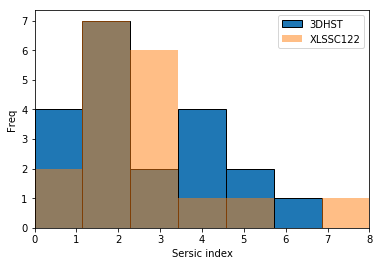

In [121]:
bins = np.linspace(0,8,8)
# plt.hist(qdhst_df['n'], label='3DHST',bins=bins,facecolor='None',hatch='\\',edgecolor='black')
# plt.hist(qxlssc_df['n'],label='XLSSC122',bins=bins,facecolor='None',hatch='/',edgecolor='black')
plt.hist(qdhst_df['n'], label='3DHST',bins=bins,edgecolor='black')
plt.hist(qxlssc_df['n'],label='XLSSC122',bins=bins,alpha=0.5)
plt.xlabel('Sersic index')
plt.ylabel('Freq')
plt.legend()
plt.xlim(0,8)

In [131]:
from scipy.stats import ks_2samp
ks_2samp(qdhst_df['n'].tolist(),qxlssc_df['n'].tolist())

Ks_2sampResult(statistic=0.28787878787878796, pvalue=0.3269955581435324)

### Visualize galfits, obvious failures?

     ID          ra       dec      re  re_err      ar  ar_err       n   n_err  \
5  2816  150.141052  2.208472  4.1056   0.051  0.2629  0.0067  1.6721  0.0702   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
5  21.7114   0.0059 -0.000812  0.000343  0.151182           0  


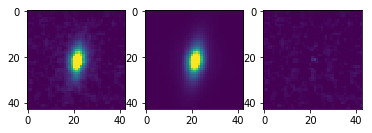

     ID          ra       dec      re  re_err      ar  ar_err      n   n_err  \
7  3285  150.109985  2.212173  1.7294  0.1924  0.3991  0.0602  4.854  1.6818   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  23.4281   0.0724 -0.003519  0.000477  0.151586           0  


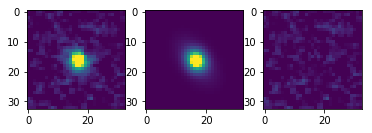

      ID          ra       dec     re  re_err      ar  ar_err       n   n_err  \
11  3648  150.133865  2.215488  2.898  0.1131  0.6111  0.0311  1.3984  0.1974   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
11  23.148   0.0196 -0.002546  0.000347  0.172077           0  


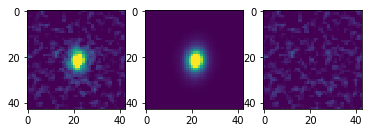

      ID          ra       dec       re  re_err      ar  ar_err       n  \
13  4158  150.121658  2.220574  15.1807  1.6612  0.6127  0.0331  1.5206   

     n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
13  0.1747  22.9713   0.0851 -0.002993  0.000108  0.165951           0  


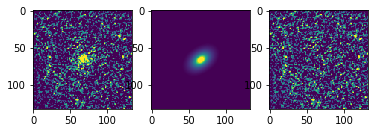

      ID          ra       dec      re  re_err      ar  ar_err       n  \
19  5276  150.153915  2.232322  2.7853  0.1495  0.6502  0.0232  4.2657   

     n_err     mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
19  0.4903  22.181    0.034 -0.001262  0.000357  0.153462           0  


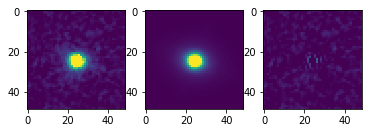

      ID         ra       dec      re  re_err      ar  ar_err      n   n_err  \
21  5469  150.17923  2.233675  4.3313  0.3142  0.6374  0.0429  1.389  0.2268   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
21  23.6569   0.0546 -0.003279  0.000311  0.172571           0  


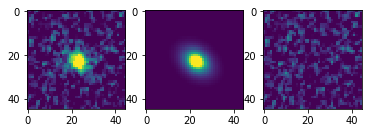

      ID         ra       dec      re  re_err      ar  ar_err      n  n_err  \
25  6159  150.17186  2.240702  4.9819  0.1985  0.8721  0.0328  0.689  0.087   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
25  23.4701   0.0208 -0.002903  0.000223  0.172187           0  


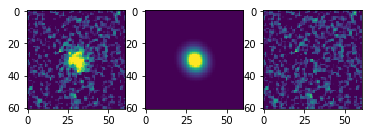

      ID          ra       dec      re  re_err     ar  ar_err       n   n_err  \
27  6960  150.081253  2.249852  6.7798   0.445  0.721  0.0278  1.7196  0.1529   

        mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
27  22.7842   0.0468 -0.00362  0.000213  0.165951           0  


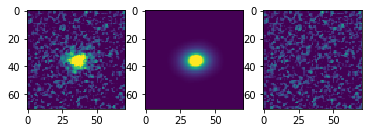

      ID          ra       dec     re  re_err     ar  ar_err      n   n_err  \
32  8006  150.067383  2.261297  2.026  0.1216  0.578  0.0398  1.266  0.3335   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
32  23.7117   0.0214 -0.001351  0.00042  0.161687           0  


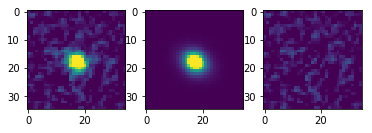

       ID          ra      dec      re  re_err      ar  ar_err       n  \
54  10719  150.070587  2.28919  9.3672  4.6089  0.5246   0.033  0.0503   

     n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
54  0.0923  24.0147   0.0488 -0.003836  0.000163  0.167837           0  


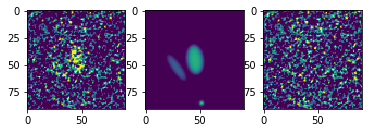

       ID          ra       dec      re  re_err      ar  ar_err        n  \
59  11271  150.164093  2.294364  1.0841  0.2328  0.8258  0.0679  10.8753   

     n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
59  6.3997  22.5745   0.1981 -0.005441  0.001128  0.169357          16  


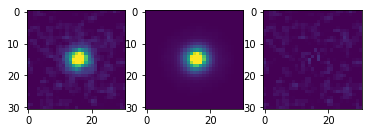

       ID          ra       dec      re  re_err      ar  ar_err       n  \
60  11494  150.073929  2.297983  7.1712  0.6995  0.8278  0.0132  5.8337   

     n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
60  0.4181  20.8686   0.0475 -0.006051  0.000557  0.156215           0  


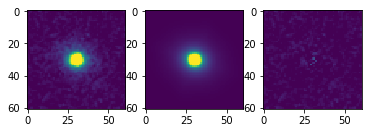

       ID        ra      dec      re  re_err      ar  ar_err      n   n_err  \
75  13083  150.0961  2.31347  2.5072  0.0668  0.8238  0.0217  2.413  0.1972   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
75  22.1009   0.0171 -0.001164  0.000349  0.155391           0  


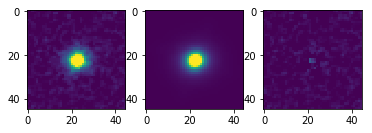

       ID          ra       dec      re  re_err      ar  ar_err       n  \
88  15833  150.164597  2.340981  1.6127   0.216  0.6132  0.0905  3.6689   

     n_err      mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
88  1.6621  23.8945   0.0907 -0.00194  0.000503  0.143677           0  


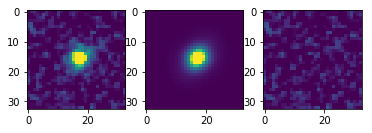

       ID          ra       dec      re  re_err      ar  ar_err       n  \
94  16548  150.082474  2.348152  4.4698  0.7113  0.3921  0.0383  3.5074   

     n_err      mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
94  0.8711  23.5292   0.0951 -0.00184  0.000324  0.154244           0  


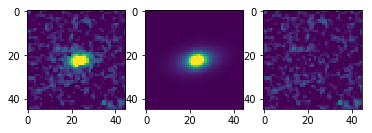

        ID          ra      dec      re  re_err      ar  ar_err       n  \
103  18369  150.093018  2.36639  0.8928  0.0525  0.8515  0.0675  3.4452   

      n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
103  0.8925  22.9825   0.0291 -0.002947  0.000473  0.140912           0  


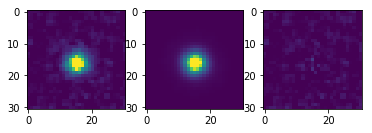

        ID          ra       dec      re  re_err      ar  ar_err       n  \
105  18668  150.129288  2.369574  5.7939  0.1589  0.5562   0.015  0.4689   

      n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
105  0.0591  23.2281   0.0207 -0.003503  0.000265  0.164978           0  


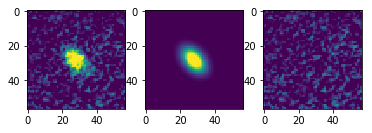

        ID          ra       dec      re  re_err      ar  ar_err        n  \
109  18977  150.146515  2.372313  0.9276  0.4175  0.9374   0.109  16.4071   

      n_err      mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
109  18.785  22.8708   0.4432 -0.00431  0.001046  0.161754          16  


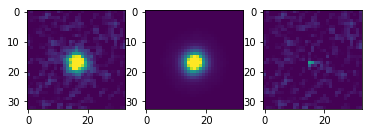

        ID          ra       dec      re  re_err      ar  ar_err       n  \
113  20143  150.174057  2.384071  2.6736  0.1902  0.7717  0.0629  1.9877   

      n_err      mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
113  0.5036  23.8299   0.0582 -0.003058  0.00033  0.154583           0  


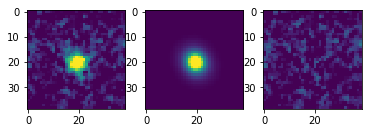

        ID          ra       dec      re  re_err      ar  ar_err       n  \
117  20983  150.108505  2.393802  6.7039  0.7567  0.7851   0.019  4.7861   

      n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
117  0.4486  21.6971   0.0595 -0.002643  0.000403  0.161531           0  


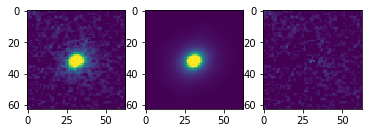

        ID          ra       dec      re  re_err      ar  ar_err       n  \
124  22979  150.079529  2.414085  7.5254  0.3582  0.3586  0.0177  0.7132   

      n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
124  0.1009  23.5903   0.0341 -0.002345  0.000228  0.219148           0  


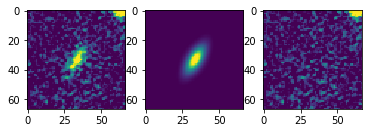

        ID          ra       dec      re  re_err      ar  ar_err       n  \
126  23734  150.141769  2.422273  9.4698  2.8694  0.7628  0.0546  3.4039   

      n_err      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
126  0.8138  23.0134   0.1898 -0.004046  0.000354  0.170265           0  


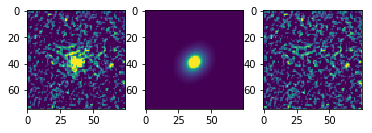

In [96]:
galfit_filename = '3DHST_z2_full_data_cps_sigma_rms_meanexp_cps_w5HLR_F140W_PSF_5min_CONV64_CONSTR_DYNMAG'
for ID in qdhst_df['ID']:
    gfh.plot_by_ID(ID,save_name=galfit_filename,survey='3DHST')

    ID         ra       dec       re   re_err     ar  ar_err       n   n_err  \
1  455  34.422282 -3.763513  58.3945  38.9567  0.867  0.0132  8.0006  1.4512   

       mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
1  20.2758   0.3732 -0.0216   0.0022  1.022178           0  


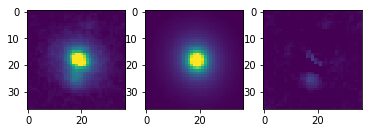

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
2  661  34.434096 -3.757658  4.4956  0.1854  0.8957  0.0099  3.0743  0.1384   

       mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
2  22.0689   0.0269  0.005471  0.00042  0.305518           0  


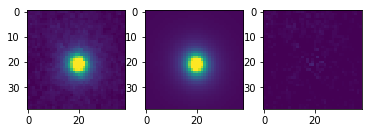

     ID        ra       dec     re  re_err      ar  ar_err       n   n_err  \
3  1036  34.43245 -3.749924  7.635  0.9149  0.5144  0.0085  5.0309  0.4047   

       mag  mag_err     sky   sky_err    chi2nu  ErrorValue  
3  21.9548   0.0652 -0.0047  0.000743  0.393766           0  


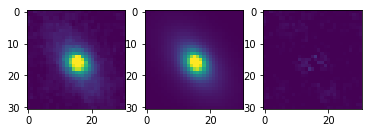

    ID         ra       dec      re  re_err      ar  ar_err      n   n_err  \
4  300  34.435031 -3.767948  2.2217  0.0403  0.7417  0.0139  2.574  0.1577   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
4  22.4572   0.0155  0.000867  0.000386  0.477339           0  


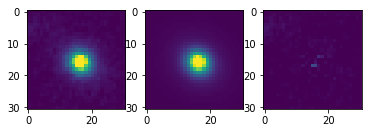

    ID         ra       dec       re   re_err      ar  ar_err        n  \
6  305  34.447153 -3.768007  33.0474  18.1894  0.4051  0.0085  11.2109   

    n_err      mag  mag_err       sky   sky_err   chi2nu  ErrorValue  
6  1.9749  21.5549   0.2298 -0.004301  0.000821  0.31243          16  


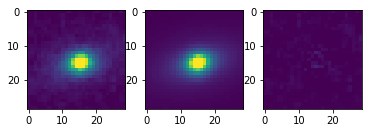

     ID         ra       dec      re  re_err     ar  ar_err       n   n_err  \
7  1057  34.436886 -3.750173  3.3123  0.0364  0.512  0.0081  1.6321  0.0645   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  22.7747   0.0097  0.000222  0.000191  0.254961           0  


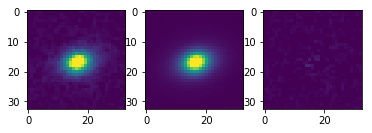

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
8  1065  34.435917 -3.749538  4.5865  0.3128  0.3704  0.0405  0.9374  0.2062   

       mag  mag_err    sky  sky_err   chi2nu  ErrorValue  
8  22.7974   0.0418  0.018   0.0009  16.4658           0  


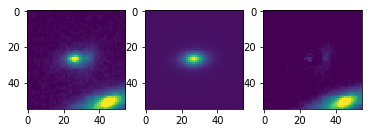

    ID        ra       dec      re  re_err      ar  ar_err       n   n_err  \
9  608  34.43845 -3.760699  2.4748   0.033  0.7395  0.0117  1.2098  0.0633   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
9  22.8834   0.0075 -0.001608  0.000237  0.364514           0  


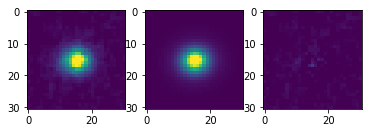

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
10  243  34.422417 -3.770003  2.3622    0.04  0.5984  0.0127  2.1707  0.1341   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
10  22.5412   0.0137 -0.000624  0.000388  0.422937           0  


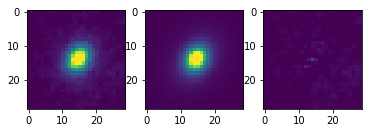

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
12  847  34.434697 -3.754887  1.7601  0.0445  0.8436  0.0203  1.9367  0.1745   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
12  23.3887   0.0162  0.002131  0.000268  0.272354           0  


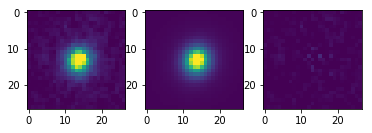

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
14  735  34.425011 -3.758034  2.7416  0.0741  0.4809  0.0144  2.5999  0.1981   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
14  23.211    0.021 -0.002149  0.000269  0.261132           0  


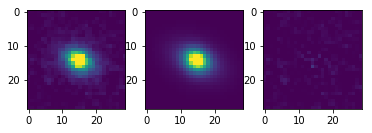

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
15  1223  34.443347 -3.745001  1.4219  0.0387  0.7848  0.0211  2.1902  0.2149   

        mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
15  23.3667   0.0147 -0.00089  0.000284  0.270796           0  


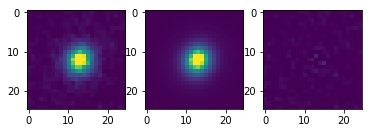

     ID         ra       dec      re  re_err    ar  ar_err      n   n_err  \
16  347  34.441846 -3.766667  4.4635  0.2679  0.66  0.0185  2.055  0.1856   

        mag  mag_err       sky  sky_err   chi2nu  ErrorValue  
16  23.3954   0.0457 -0.000567  0.00035  0.29589           0  


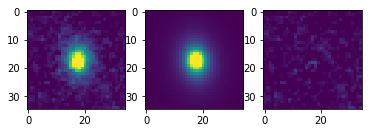

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
18  497  34.433001 -3.763179  3.2202  0.5304  0.9952   0.029  4.1534  0.6712   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
18  23.1779   0.0958 -0.003406  0.000751  0.276813           0  


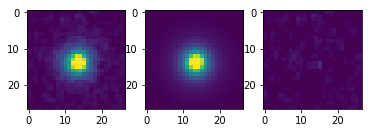

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
22  731  34.439754 -3.758259  1.4761  0.0496  0.6853  0.0279  1.9274  0.2479   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
22  23.7861   0.0161 -0.002598  0.00025  0.269558           0  


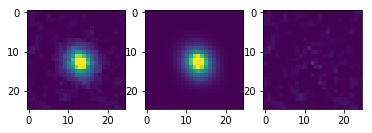

     ID         ra       dec       re    re_err      ar  ar_err        n  \
23  653  34.433963 -3.759267  28.3481  103.8835  0.6027  0.0586  15.8383   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
23  17.0176  22.8625   1.2796  0.0148   0.0012  0.741288          16  


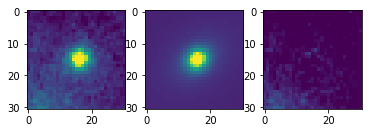

     ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
25  726  34.430604 -3.757624  10.4533  0.3099  0.7094  0.0134  1.0001  0.0401   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
25  23.2616   0.0232 -0.001143  0.000062  0.276562           0  


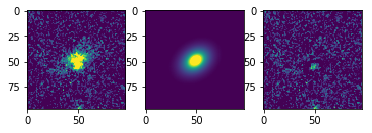

     ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
34  434  34.446607 -3.764467  12.1055  1.3054  0.3985  0.0144  2.6135  0.2527   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
34  23.4476   0.0739 -0.001211  0.00012  0.259161           0  


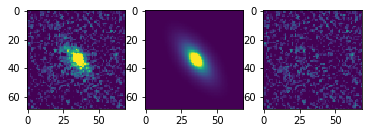

In [136]:
galfit_filename = 'XLSSC122_3ARCSEC_STELLAR_PSF_data_cps_sigma_rms_cps_w5HLR_639_3arcsec_PSF_5min_CONV128_CONSTR_DYNMAG'
for ID in qxlssc_df['ID']:
    gfh.plot_by_ID(ID,save_name=galfit_filename,survey='HST')

In [137]:
qxlssc_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,...,snr,spec-id,zhi,zlo,zz,mass,mass_err,re_kpc,re_err_kpc,re_maj_kpc
1,455,34.422282,-3.763513,4.6240,0.0721,0.9368,0.0087,2.9442,0.0643,21.7323,...,22.31920,451,1.981299,1.974240,1.980749,10.755394,0.087396,2.374924,0.037031,2.453727
2,661,34.434096,-3.757658,4.4956,0.1854,0.8957,0.0099,3.0743,0.1384,22.0689,...,18.51870,657,1.987677,1.979659,1.982701,11.251713,0.032812,2.308749,0.095214,2.439470
3,1036,34.432450,-3.749924,7.6350,0.9149,0.5144,0.0085,5.0309,0.4047,21.9548,...,17.43010,1032,1.982618,1.976072,1.981512,10.689293,0.096161,3.921247,0.469882,5.467310
4,300,34.435031,-3.767948,2.2217,0.0403,0.7417,0.0139,2.5740,0.1577,22.4572,...,16.91640,295,1.989074,1.984283,1.986897,10.968724,0.013495,1.140727,0.020692,1.324548
6,305,34.447153,-3.768007,11.3433,0.9366,0.4094,0.0070,7.3004,0.3759,22.0240,...,11.84510,298,1.995379,1.990165,1.992867,10.822529,0.076894,5.822411,0.480748,9.099740
7,1057,34.436886,-3.750173,3.3123,0.0364,0.5120,0.0081,1.6321,0.0645,22.7747,...,11.80230,1050,1.982959,1.974407,1.977232,10.581541,0.108340,1.701524,0.018699,2.377953
8,1065,34.435917,-3.749538,4.5865,0.3128,0.3704,0.0405,0.9374,0.2062,22.7974,...,11.22480,1064,1.996971,1.983367,1.987974,10.741509,0.106439,2.354800,0.160598,3.869176
9,608,34.438450,-3.760699,2.4748,0.0330,0.7395,0.0117,1.2098,0.0633,22.8834,...,10.55160,606,1.971139,1.961619,1.965895,10.308117,0.118456,1.272015,0.016962,1.479187
10,243,34.422417,-3.770003,2.3622,0.0400,0.5984,0.0127,2.1707,0.1341,22.5412,...,10.08480,240,1.979908,1.974125,1.977416,10.231026,0.137707,1.213448,0.020548,1.568648
12,847,34.434697,-3.754887,1.7601,0.0445,0.8436,0.0203,1.9367,0.1745,23.3887,...,8.00614,845,1.983010,1.974247,1.979286,10.347347,0.146519,0.904068,0.022857,0.984312
